In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path_base = '/content/gdrive/My Drive/Colab Notebooks/psel_birdie_ds/'

In [0]:
! pip install unidecode

import pandas as pd
import numpy as np
import json
import re
from matplotlib import pyplot as plt
from unidecode import unidecode

# 1. Teste Classificação

## Preparando a base de dados

In [0]:
# carrega arquivo de smartphones
smart = json.load(open(path_base + 'data/smartphones_.json'))
smart = pd.DataFrame(smart)

# carrega arquivo de não smartphones
n_smart = json.load(open(path_base + 'data/nao_smartphones.json'))
n_smart = pd.DataFrame(n_smart)

In [0]:
# quantidade de smartphones
n = smart.shape[0]

# # concatena os dois dataframes amostrando n instâncias dos não smartphones
# data = pd.concat([smart, n_smart.sample(n, replace=False)])

# concatena os dois dataframes
data = pd.concat([smart, n_smart])

In [0]:
# palavras chave de smartphone e de não smartphones
key_words = ['capa', 'capinha', 'case', 'pelicula', 'acessorio', 'tablet', 
             'tab ', 'relogio', 'smartwatch', 'bumper', 'bumber', 'protetores', 
             'protetor', 'suporte', 'kit', 'cabo', 'bracadeira', 'ipad', 
             'adesivo', 'lentes', 'lente', 'carregador', 'repetidor', 
             'espelhamento', 'mirror', 'antena', 'watch', 'interface' ] + [
             'smartphone', 'celular', 'iphone', 'galaxy', 'samsung a', 
             'samsung j', 'moto ', 'xperia', 'zenfone', 'lg k', 'xiaomi mi', 
             'rom global', 'xiaomi redmi', 'oneplus', 'caterpillar cat', 'motorola nextel']

In [0]:
# cada palavra vira uma feature
for kw in key_words:
    data[kw] = data['titulo'].apply(lambda x: 1 if kw in unidecode( x.lower() ) else 0)    

In [0]:
# separa o dataset em target e data (somente as features)
target = data['categoria'].apply(lambda x: 0 if x=='nao-smartphone' else 1)
data = data.loc[:, 'capa':'motorola nextel']

## Encontrando o melhor K

In [0]:
# função que treina e testa o KNN com cross validation (5 folds) variando o k de 1 a 100 
# retorno: uma tupla contendo o erro médio quadrático em treino e teste para cada uma das 100 execuções (sendo 5 execuções para cada uma das 100)
def err_k(data, target):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import KFold

    kf = KFold(10, shuffle=True)
    k_range = range(1, 50)
    err_test = np.zeros( (len(k_range), 10) )
    err_train = np.zeros( (len(k_range), 10) )

    for k in k_range:
        clf = KNeighborsClassifier(k)

        for i, (train_index, test_index) in enumerate(kf.split(data)):
            # separa conjunto de treino e de teste
            x_train, x_test = data.iloc[train_index], data.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]

            # treinando o modelo
            clf = clf.fit(x_train, y_train)

            # predizendo em teste (classificando)
            y_pred = clf.predict(x_test)
            err_test[k-1][i] = ( mean_squared_error(y_test, y_pred) )

            # predizendo em treino
            y_pred = clf.predict(x_train)
            err_train[k-1][i] = ( mean_squared_error(y_train, y_pred) )   

    return err_train, err_test

In [0]:
# cria um dataset menor para encontrar os diferentes valores de k
s = int( (  smart.shape[0]/(smart.shape[0]+n_smart.shape[0])) * 4000 )
n = int( (n_smart.shape[0]/(smart.shape[0]+n_smart.shape[0])) * 4000 )

df = pd.concat([data[target==1].sample(s, replace=False), 
                data[target==0].sample(n, replace=False)])

# obtem o erro em teste e treino para diferentes valores de k
err_train, err_test = err_k(df, target)

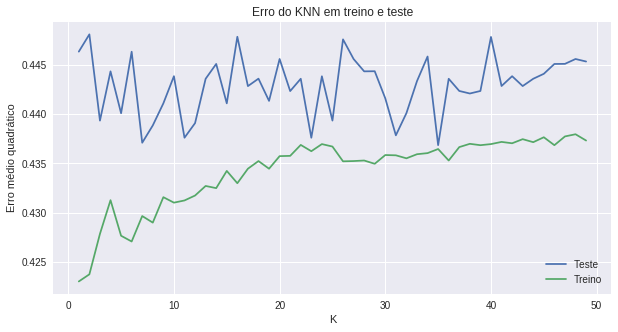

In [99]:
# plot do erro em teste e treino
plt.figure( figsize=(10, 5) )

x = range(1, err_train.shape[0]+1)

y_train     = err_train.mean(axis=1)
y_test      = err_test.mean(axis=1)

plt.plot(x, y_test, label="Teste")
plt.plot(x, y_train, label="Treino")

plt.title("Erro do KNN em treino e teste")
plt.xlabel("K")
plt.ylabel("Erro médio quadrático")
plt.legend(loc="lower right")

plt.show()

## Classificadores

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [0]:
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(35)
lda = LDA()
qda = QDA()

clfs = (dt, knn, lda, qda)
clfs_name = ("Árvore de decisão", "KNN", "LDA", "QDA")

kf = KFold(n_splits=10, shuffle=True)
score = {name : np.zeros(10) for name in clfs_name}
y_proba = {name : () for name in clfs_name}

for i, (clf, clf_name) in enumerate( zip(clfs, clfs_name) ):
    for j, (train_index, test_index) in enumerate( kf.split(data) ):
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # treinando o modelo
        clf = clf.fit(x_train, y_train)

        # predizendo valores (classificando)
        y_pred = clf.predict(x_test)
        y_pred_proba = clf.predict_proba(x_test)[:, 1]
        
        score[clf_name][j] = accuracy_score(y_test, y_pred)
        
        # armazena uma tupla com o y teste, y proba e y predito do classificador clf_name
        y_proba[clf_name] = (y_test, y_pred_proba, y_pred)

### Acurácia

No handles with labels found to put in legend.


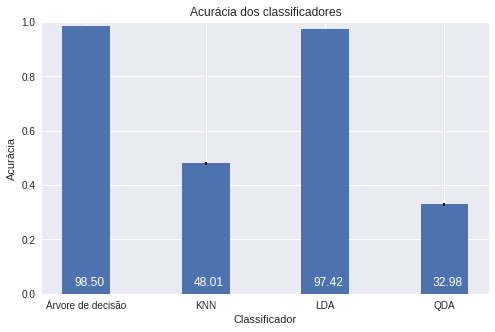

In [107]:
# plot da acuracia
plt.figure(figsize=(8, 5))

x = np.arange(len(clfs_name))
y = [ score[clf].mean() for clf in clfs_name ]
y_err = [ score[clf].std() for clf in clfs_name ]

plt.bar(x, y, yerr=y_err, width=0.4)

for i, v in enumerate(y):
    plt.text(i-0.1, 0.03, '%.2f'%(v*100), color='white')
      
plt.title("Acurácia dos classificadores")
plt.xlabel("Classificador")
plt.ylabel("Acurácia")
plt.xticks(x, clfs_name)
plt.legend(loc="upper left")
plt.ylim(0, 1)

plt.show()

### Curva ROC

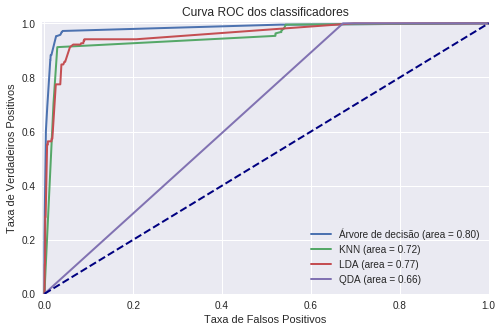

In [108]:
from sklearn.metrics import roc_curve, roc_auc_score
  
# plot da curva ROC
plt.figure(figsize=(8, 5))

# uma curva para cada classificador
for clf in clfs_name:
    # calcula curva ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_proba[clf][0], y_proba[clf][1])
    roc_auc = roc_auc_score(y_proba[clf][0], y_proba[clf][2])
    
    # plota curva ROC
    plt.plot(fpr, tpr, lw=2, label=clf + ' (area = %0.2f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title("Curva ROC dos classificadores")
plt.legend(loc="lower right")

plt.show()

## Classificando e salvando a saída

In [0]:
# carregando o arquivo com os produtos a serem classificados
data_estag = pd.read_csv(path_base + 'data/data_estag_ds.tsv', sep='\t')

In [0]:
# criando as features (cada palavra vira uma feature)
for kw in key_words:
    data_estag[kw] = data_estag['TITLE'].apply(lambda x: 1 if kw in unidecode( x.lower() ) else 0)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# instanciando o classificador
clf = DecisionTreeClassifier()

# treinando o modelo
clf = clf.fit(data, target)

# predizendo valores (classificando)
data_estag['categoria'] = clf.predict(data_estag.loc[:, 'capa':'motorola nextel'])

In [0]:
# convertendo a categoria de 0/1 para smartphone/não-smartphone
data_estag['categoria'] = data_estag['categoria'].apply(lambda x: 'smartphone' if x==1 else 'não-smartphone')

In [0]:
# salvando o arquivo csv
data_estag[['ID', 'TITLE', 'categoria']].to_csv(path_base+'out/produtos_classificados.csv', index=False)

# 2. Teste Extração de atributos

In [0]:
# cria o dataframe de smartphones a partir dos dados que foram classificados como 'smartphone'
data = data_estag[['ID', 'TITLE', 'categoria']]
smartphones = data.query('categoria == "smartphone"').drop('categoria', axis=1)

In [0]:
# extrai a marca do smartphone utilizando o título da oferta
def marca(title):
    # lista de marcas de smartphone extraída do buscapé
    marcas = ('Motorola', 'Samsung', 'Asus', 'LG', 'Apple', 'Alcatel', 'Multilaser', 'Xiaomi', 'Positivo', 'Sony', 'Quantum', 'DL', 'BLU', 'Mirage', 'BlackBerry', 'iPro', 'ZTE', 'Nokia', 'QTouch', 'Bright', 'QbeX', 'LenoxxSound', 'Lenovo', 'Microsoft', 'TCL', 'Philco', 'Huawei', 'Mox', 'TP-Link', 'Freecel', 'Meizu', 'Caterpillar')

    for marca in marcas:
        if marca.lower() in unidecode( title.lower() ) :
            return(marca)

    if 'moto ' in unidecode( title.lower() ):
        return 'Motorola'
    elif 'galaxy ' in unidecode( title.lower() ):
        return 'Samsung'
    else:
        return np.nan

In [0]:
# extrai a quantidade de memória ram do smartphone utilizando o título da oferta
def ram(title):
    # procura um número antes da palavra 'ram'
    m1 = re.findall('(\d+)((?!\d).)*ram', unidecode( title.lower()) ) 
    if m1:
        ram1 = np.float( m1[0][0])

    # procura um número depois da palavra 'ram'
    m2 = re.findall('ram((?!\d).)*(\d+)', unidecode( title.lower()) ) 
    if m2:
        ram2 = np.float( m2[0][1])

    # se existe número antes e depois de 'ram'
    if m1 and m2:
        if ram1>0 and ram2>0:
            return min(ram1, ram2)
        elif ram1>0:
            return ram1
        else:
            return ram2
    elif m1:
        return ram1
    elif m2:
        return ram2
    else:    
        return np.nan

In [0]:
# extrai o tamanho da tela do smartphone utilizando o título da oferta
def tela(title):

    # expressões regulares para tentar extrair o tamanho da tela
    expressions = (" \d(?:\.|,){0,1}\d{0,2}(?:(?:\'{1,2})|\")", "tela(?: de | )\d(?:\.|,){0,1}\d{0,2}")

    for exp in expressions:
        tela = re.findall(exp, unidecode( title.lower()) )

    # se deu match, extrai somente o número e converte para float
    if tela:
        tela = tela[0]
        return float( re.findall(r'\d(?:\.|,){0,1}\d{0,2}', tela)[0].replace(',', '.'))
    else:
        return np.nan

In [0]:
# extrai a cor do smartphone utilizando o título da oferta
def cor(title):
  
    # lista de cores de smartphones extraída do próprio arquivo disponibilizado
    cores = ('Preto', 'Branco', 'Cinza', 'Dourado', 'Verde', 'Grafite', 'Black Piano', 'Titânio', 'Titanium', 'Prata', 'Platinum ', 'Ametista', 'Azul Safira', 'Azul Topázio', 'Ouro Rose', 'Rose Gold ', 'Azul', 'Ouro', 'Gold', 'Vermelho', 'Rosa', 'Ultravioleta', 'Indigo', 'Marrom')

    for cor in cores:
        if unidecode( cor.lower() ) in unidecode( title.lower() ) :
            return(cor)

    return np.nan

In [0]:
# obtendo atributos
smartphones.loc[:, 'marca'] = smartphones.loc[:, 'TITLE'].apply(marca)
smartphones.loc[:, 'ram']   = smartphones.loc[:, 'TITLE'].apply(ram)
smartphones.loc[:, 'tela']  = smartphones.loc[:, 'TITLE'].apply(tela)
smartphones.loc[:, 'cor']   = smartphones.loc[:, 'TITLE'].apply(cor)

# salvando arquivo com atributos
smartphones.to_csv(path_base+'out/smartphones_atributos.csv', index=False)

# 3. Teste de Matching / Deduplicação

In [0]:
# Função que calcula a similaridade de duas strings, retirada do post "Overview of Text Similarity Metrics in Python" e levemente modificada
# Diponível em: https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50
def get_jaccard_sim(str1, str2): 
    a = set(unidecode(str1).lower().split()) 
    b = set(unidecode(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
# obtem a quantidade de smartphones
n = smartphones.shape[0]

# renomeia os indices do dataframe para facilitar a iteração sobre as linhas
ind = {old : new for (old,new) in zip(smartphones.index, range(n))}
smartphones = smartphones.rename(index=ind)

In [0]:
import csv, math

# abre o arquivo csv de matchs e vai salvando cada match encontrado
with open(path_base+'out/smartphones_duplicados.csv', 'w', newline='') as csvfile:
    fieldnames = ['ID 1', 'Titulo 1', 'ID 2', 'Titulo 2', 'Similaridade', 'Especificações iguais', 'Especificações diferentes']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
  
    for index1, row1 in smartphones.iloc[:n-1, :].iterrows():
        for index2, row2 in smartphones.iloc[index1+1:, :].iterrows():

            # verifica se os atributos (marca, ram e tela) são iguais
            if (
              (row1['marca'] == row2['marca'] or str(row1['marca']) == 'nan' or str(row2['marca']) == 'nan') and 
              (row1['ram'] == row2['ram'] or str(row1['ram']) == 'nan' or str(row2['ram']) == 'nan') and 
              (row1['tela'] == row2['tela'] or str(row1['tela']) == 'nan' or str(row2['tela']) == 'nan')
            ):
                # obtém a similaridade de jaccard
                sim = get_jaccard_sim(row1['TITLE'], row2['TITLE'])

                if sim >= 0.84:
                    att_eq = [] #atributos iguais
                    att_dif = [] #atributos diferentes

                    # itera pelos atributos para obter os que são iguais e os que são diferentes
                    for ((l, a1), a2) in zip( row1.loc['marca':'cor'].iteritems(), row2.loc['marca':'cor'] ):
                        if a1 == a2:
                            att_eq.append( l+': '+str(a1) )
                        elif str(a1) != 'nan' or str(a2) != 'nan':
                            att_dif.append( l+': '+str(a1)+', '+str(a2) )        

                        writer.writerow( {'ID 1'                      : row1['ID'], 'Titulo 1': row1['TITLE'], 
                                    'ID 2'                      : row2['ID'], 'Titulo 2': row2['TITLE'], 
                                    'Similaridade'              : sim,
                                    'Especificações iguais'     : '; '.join( att_eq ),
                                    'Especificações diferentes' : '; '.join( att_dif )
                                   } )